# Optimization TSP



In this task we are going to perform a optimization algorithm to solve the traveller(TSP) problem.

In [1]:
import pandas as pd
import numpy as np
import random
import operator
from matplotlib import pyplot as plt

First of all we are going to extract our .TSP file so that we can work with it.

In [2]:
# =============================================================================
# Extracting and importing TSP file
# =============================================================================
infile = open('berlin52.tsp', 'r')
print(infile)
Name = infile.readline().strip().split()[1] # NAME
FileType = infile.readline().strip().split()[1] # TYPE
Comment = infile.readline().strip().split()[1] # COMMENT
Dimension = infile.readline().strip().split()[1] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
infile.readline()

nodelist = []
N = int(Dimension)
for i in range(0, int(Dimension)):
    x,y = infile.readline().strip().split()[1:]
    nodelist.append([float(x), float(y)])

<_io.TextIOWrapper name='berlin52.tsp' mode='r' encoding='cp1252'>


Now we are going to create a city class that allow us to handle cities and calculate the
distance between two cities.

In [3]:
# =============================================================================
# City Class
# =============================================================================
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Now we create a fitness class wich is calculated by the inverse of the route 
distance as we want to minimize the route distance a bigger fitness implies 
a lower route distance

In [4]:
# =============================================================================
# Fitness Class
# =============================================================================

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1/(float(self.routeDistance()))
        return self.fitness

We iniciate now a random order to visit the cityes as our initial point (our first individual)

In [5]:

# =============================================================================
# Population creation Class (One individual)
# =============================================================================

def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


In [6]:
# =============================================================================
# Population creation Class (Full population)
# =============================================================================

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


The next thing is to create a function that sorts the routes by reversed Fitness because we want to maximize the Fitness value. **With a lower distance the bigger the fitness is. Fitness = 1/distance.**

In [7]:
# =============================================================================
# Determine Fitness (Survival of the population)
# =============================================================================
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
        
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Now we define the selecction of the parents by  the roulette method and then 
we start and select the mating process

In [8]:
# =============================================================================
# Selection And Creation of the mating
# =============================================================================

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    
    maximoP = popRanked[0][0]      
    maximoNG = selectionResults[0]
    for k in selectionResults:
        if (selectionResults[k] > maximoNG):
            maximoNG = selectionResults[k]
    
    minimoNG = selectionResults[0]
    for h in selectionResults:
        if (selectionResults[h] < minimoNG):
            minimoNG = selectionResults[h]

    if (maximoP > maximoNG):
        selectionResults.remove(minimoNG)
        selectionResults.append(maximoP)
    

    return selectionResults

In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

After getteng the parents we have to generate the childrens

In [10]:
# =============================================================================
# Parenting
# =============================================================================

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [11]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

With the children created we have to create the mutation process.

In [12]:
# =============================================================================
# Mutation of the children
# =============================================================================

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city1
            individual[swapWith] = city2
    return individual

In [13]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Now we put all the steps together in a function so that we have it organized

In [14]:
# =============================================================================
# Function that creates a next generation by unifying all above
# =============================================================================

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [15]:
# =============================================================================
#                       PLot improvements
# =============================================================================

def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    # Plotting fitness curve
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    
    # Plotting best route
    xp = []
    yp = []
    
    for city in bestRoute:
        xp.append(float(city.x))
        yp.append(float(city.y))
    
    
    plt.scatter(xp,yp)
    plt.plot(xp,yp)
    plt.show()

Initial distance: 25765.802602864704
Final distance: 8076.700381276488


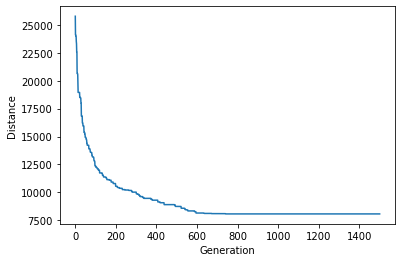

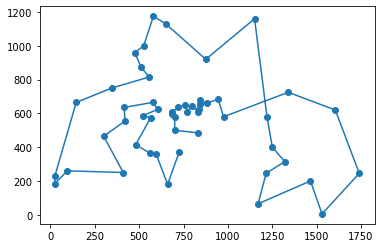

In [16]:
# =============================================================================
# Initializing data and running algorithm
# =============================================================================


cityList = []

for i in range(0,len(nodelist)):
    cityList.append(City(x=int(nodelist[i][0]), y=int(nodelist[i][1])))
    

# Run the plot
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=25, mutationRate=0.1, generations=1500)

**Conclusion**

The final distance should be 7500, we managed to get a 8076.700381276488 wich is not bad, but it is not perfect, we could make it better by redefining the mutation and breding functions. As we have to do the next module tasks we are going to leave it for the synchronous week.